# Final Project

As in all machine learning problems you should complete the following steps:
1. Load and explore the data (using plots and histograms )
2. Clean/preprocess/transform the data if necessary (first performed on training data and next on test data)
3. Train the machine learning model (in this assignment two models, one linear and one non-linear)
4. Evaluate and optimise the model

However, while performing the steps you should consider our main goals and research questions for doing this project and try to adress them. This can be either in each step or afterwards in discussion and conclusion section (your call!). Below are the research question we are interested in:

* What are the necessary step to clean and prepare the dataset as we have categorial features and missing data.
* What model/classifier provides the best result for this application.
* What is the best choice for our cost function and performance metrics for this problem.

Please also note the following points during the assignment:

* Use functions from open source libraries like sci-kit learn and keras and avoid using your own hand-written functions from previous assignments. You can also use our [cheatsheet](https://colab.research.google.com/drive/12h-QBlsaWXkjGIRoJXfF4yqi1elnX9qn?usp=sharing).
* Feel free to contact us on Teams if you need more description.
* This notebook is structured like a scientific paper. The text should provide a high-level overview of your approach. Please don't include any details about your code in the text but add them as comments in the code itself. Your code should be cleane and readable with enough comments.
* There are some instructions and questions in each section, remove the highlighted text in blue and replace it with your explanations and answers.

You can delete this section before submission.

## 1. Introduction


<font color=#bcaeff>Jesse Wessteijn, Jessteijn <br>
                    Evert-Jan Beiboer, evertjanbeiboer <br>
                    score: , Leaderboard rank:

## 2. Data


### 2.1 Dataset

In [4]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import NuSVR
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import numpy as np
import pandas as pd
import os

In [5]:
data = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [7]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def featuresx(x_data, X, segment):
    X.loc[segment, 'ave'] = x_data.mean()
    X.loc[segment, 'std'] = x_data.std()
    X.loc[segment, 'max'] = x_data.max()
    X.loc[segment, 'min'] = x_data.min()
    
    X.loc[segment, 'q01'] = np.quantile(x_data,0.01)
    X.loc[segment, 'q05'] = np.quantile(x_data,0.05)
    X.loc[segment, 'q95'] = np.quantile(x_data,0.95)
    X.loc[segment, 'q99'] = np.quantile(x_data,0.99)
    
    X.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x_data))
    X.loc[segment, 'mean_change_rate'] = calc_change_rate(x_data)
    X.loc[segment, 'abs_max'] = np.abs(x_data).max()
    X.loc[segment, 'abs_min'] = np.abs(x_data).min()

    X.loc[segment, 'max_to_min'] = x_data.max() / np.abs(x_data.min())
    X.loc[segment, 'max_to_min_diff'] = x_data.max() - np.abs(x_data.min())
    X.loc[segment, 'count_big'] = len(x_data[np.abs(x_data) > 500])
    X.loc[segment, 'sum'] = x_data.sum()

    X.loc[segment, 'abs_trend'] = add_trend_feature(x_data, abs_values=True)
    X.loc[segment, 'abs_mean'] = np.abs(x_data).mean()
    X.loc[segment, 'abs_std'] = np.abs(x_data).std()
    X.loc[segment, 'abs_median'] = np.median(np.abs(x_data))

    X.loc[segment, 'trend'] = add_trend_feature(x_data)
    X.loc[segment, 'mad'] = x_data.mad()
    X.loc[segment, 'kurt'] = x_data.kurtosis()
    X.loc[segment, 'skew'] = x_data.skew()
    X.loc[segment, 'med'] = x_data.median()
    
    X.loc[segment, 'abs_q95'] = np.quantile(np.abs(x_data),0.95)
    X.loc[segment, 'abs_q99'] = np.quantile(np.abs(x_data),0.99)
    X.loc[segment, 'F_test'], X.loc[segment, 'p_test'] = stats.f_oneway(x_data[:30000],x_data[30000:60000],x_data[60000:90000],x_data[90000:120000],x_data[120000:])
    X.loc[segment, 'av_change_abs'] = np.mean(np.diff(x_data))
        
    return X

def feature_extraction(data,segments):
    X = pd.DataFrame(index=range(segments), dtype=np.float64)
    y = pd.DataFrame(index=range(segments), dtype=np.float64,columns=['time_to_failure'])
    for segment in tqdm(range(segments)):
        seg = data.iloc[segment*rows:segment*rows+rows]
        x_data = pd.Series(seg['acoustic_data'].values)
        y_data = seg['time_to_failure'].values[-1]

        y.loc[segment,'time_to_failure'] = y_data
        
        X = featuresx(x_data, X, segment)
        
    return X, y
    

In [8]:
rows = 150_000
segments = int(np.floor(data.shape[0] / rows))

X,y = feature_extraction(data, segments)

y=y.values.flatten()
print(X.shape)
print(y.shape)

  0%|          | 0/4194 [00:00<?, ?it/s]

(4194, 30)
(4194,)


<font color=#bcaeff>We used to [this notebook](https://www.kaggle.com/code/artgor/earthquakes-fe-more-features-and-samples) for feature extration. I created a function for it, so I can use it later on the test data files.

#### 2.1.1 Train-test split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=102)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3355, 30)
(839, 30)
(3355,)
(839,)


<font color=#bcaeff>First the test value can not be too big or too small. When the test value is too big you have nothing left for training. When the test value is too small the given accuracy will not be reliable.<br>
<font color=#bcaeff> For the second question 'random_state' is used so that output will not change every restart.

### 2.2 Data Exploration

      acoustic_data  time_to_failure
0                12         1.469100
1000              6         1.469099
2000              3         1.469098
3000             29         1.469097
4000             13         1.469096
5000              6         1.468099
6000              9         1.468098
7000              0         1.468097
8000             -1         1.468096
9000              9         1.466999


Text(0.5, 0, 'Sample times 1000)')

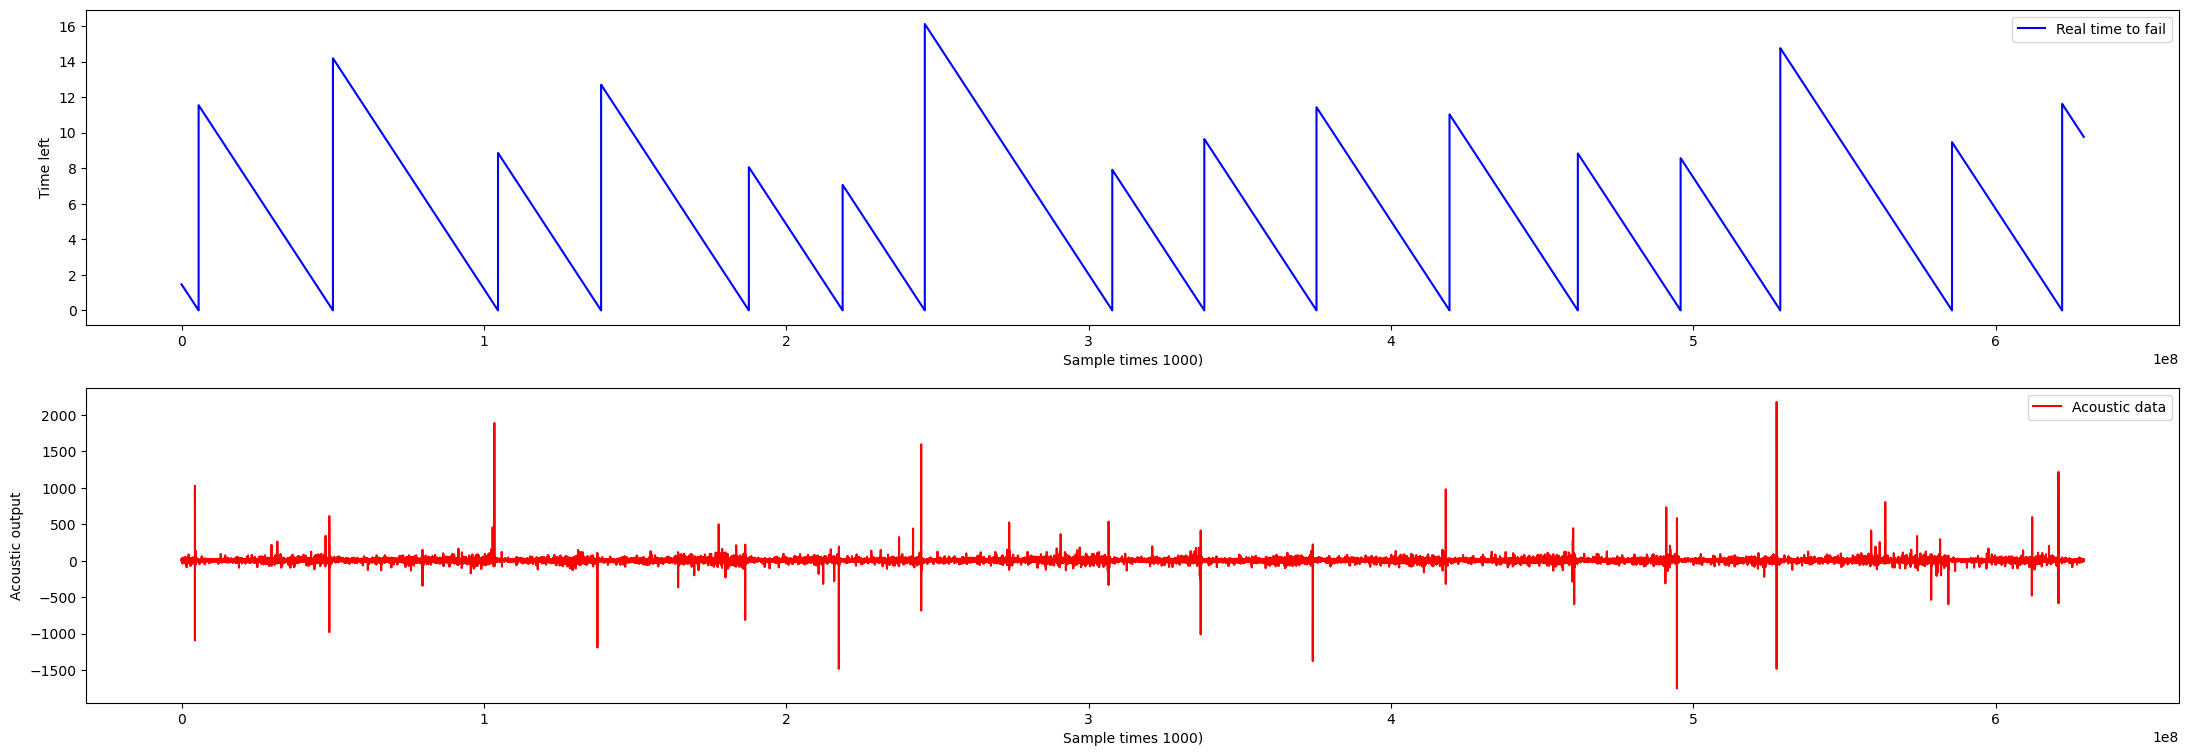

In [10]:
n=1000
y1_acoustic_data=data['acoustic_data'][::n]
y2_time_to_failure=data['time_to_failure'][::n]
print(data[0:10*n:n])


#plotting the graphs of all the deta
fig, ax = plt.subplots(2, 1, figsize=(27,9))
ax[0].plot(y2_time_to_failure, color='b')
ax[0].legend(['Real time to fail'])
ax[0].set_ylabel('Time left')
ax[0].set_xlabel('Sample times 1000)')
ax[1].plot(y1_acoustic_data, color='r')
ax[1].legend(['Acoustic data'])
ax[1].set_ylabel('Acoustic output' )
ax[1].set_xlabel('Sample times 1000)')

<font color=#bcaeff>if you plot the data you can see that the acoustic value has a peak when time of failure is zero. This is the measured earthquake

### 2.3 Data Preparation

In [11]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## 3. Training and Results

In [12]:
from sklearn.linear_model import LinearRegression
# define the model
model = LinearRegression()
# fit the model
model.fit(X_train, y_train)
# predict
predictions=model.predict(X_test)
#accuracy
score=model.score(X_test, y_test)
print(score)
mse = mean_squared_error(y_test, predictions)
print(mse)

0.4534023803770155
7.017008736175641


In [13]:
#define and fit model
nsvm = NuSVR(kernel='linear')
nsvm.fit(X_train, y_train)

# predict
predictions=nsvm.predict(X_test)
# accuracy
score=nsvm.score(X_test, y_test)
print(score)
mse = mean_squared_error(y_test, predictions)
print(mse)

0.44697377313180875
7.099536708456553


In [14]:
#define and fit model
svm = NuSVR(kernel='rbf')
svm.fit(X_train, y_train)

# predict
predictions=svm.predict(X_test)
# accuracy
score=svm.score(X_test, y_test)
print(score)
mse = mean_squared_error(y_test, predictions)
print(mse)

0.4540831746662992
7.008268962521417


In [15]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
score=tree.score(X_test, y_test)
print(score)
mse = mean_squared_error(y_test, predictions)
print(mse)

0.4421844511602614
7.161020170711449


<font color=#bcaeff>I check a lot of models, those 4 are the best in my opinion. They give the best results. Two linear models and two non-linear models were used. The non-linear svm model is the best one.

## 4. Discussion and Conclusion

In [16]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(dtype=np.float64, index=submission.index)

for seg_id in tqdm(X_test.index):
    seg = pd.read_csv('../input/LANL-Earthquake-Prediction/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test = featuresx(x, X_test, seg_id)
    
print(x.shape)
print(X_test.shape)

X_test = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test)
submission.to_csv('submission.csv')

print(submission)

  0%|          | 0/2624 [00:00<?, ?it/s]

(150000,)
(2624, 30)
            time_to_failure
seg_id                     
seg_00030f         4.342878
seg_0012b5         6.150087
seg_00184e         5.998249
seg_003339         7.985206
seg_0042cc         7.101499
...                     ...
seg_ff4236         5.610940
seg_ff7478         6.446504
seg_ff79d9         4.966563
seg_ffbd6a         2.149476
seg_ffe7cc         9.163199

[2624 rows x 1 columns]


<font color=#bcaeff>We also learned to work with big data, which leads into not being able to plot everything or make a useful table to see what you doing. This had made the understanding of the deta much harder. Furthermore our results are all under 50% which is not good, but we did not do the project to achieve a certain performance but to learn with the concept of machine learning.</font>